In [1]:
from collections import defaultdict
import json
import os
import sys
import time

from scipy.stats import mannwhitneyu
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from ete3 import PhyloTree
from rna_tools.SecondaryStructure import parse_vienna_to_pairs
import seaborn as sns
import tqdm

sys.path.append('../sourse/')
from mutations_extractor_with_context import get_sequence, node_parent, read_fasta_generator
from utils import read_ss_file

In [11]:
SUBSTITUTIONS_PATH = '../data/overall_mutations_with_context2.json'
SEC_STRUCT_PATH_PLUS = '../data/structure_data/SARSCoV2-RNA_from_site_plus_0based.ss'
REFSEQ_PATH = "../data/covid_ref.fasta"

ss_clusters = read_ss_file(SEC_STRUCT_PATH_PLUS)

In [12]:
refseq = next(read_fasta_generator(REFSEQ_PATH))[1].replace('\n', '')
print(len(refseq))

with open(SUBSTITUTIONS_PATH) as fin:
    substitutions = json.load(fin)

29903


In [14]:
refseq_len = len(refseq)
subs_by_pos = [[] for _ in range(refseq_len)]
n_overall_substitutions = 0
n_snps = 0

for parent_node, child_node, substs in substitutions:
    for pos, parent_nucl, child_nucl, _, _ in substs:
        n_overall_substitutions += 1
        # only SNPs
        if parent_nucl != '-' and child_nucl != '-':
            subs_by_pos[pos].append((parent_nucl, child_nucl, ))  # parent_node, child_node
            n_snps += 1

assert n_snps == sum(map(len, subs_by_pos))

print(f'{n_overall_substitutions} substitutions in the dataset')
print(f"{n_snps} SNPs (not indel)")

631407 substitutions in the dataset
618118 SNPs (not indel)


In [33]:
cl = ss_clusters[0]
assert len(cl[-1]) == cl[2] - cl[1] + 1  # cl[2] is end pos

/home/mr/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


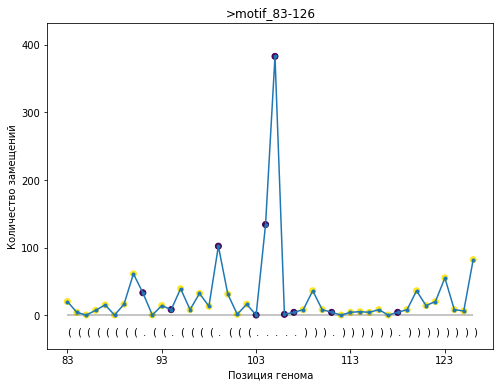

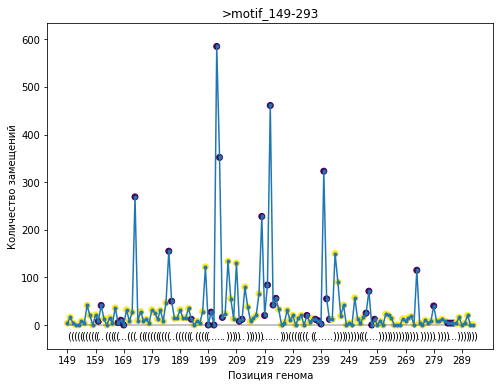

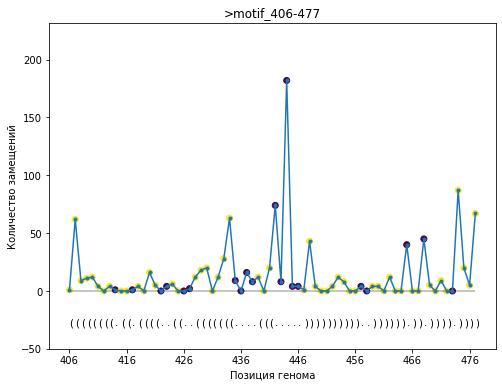

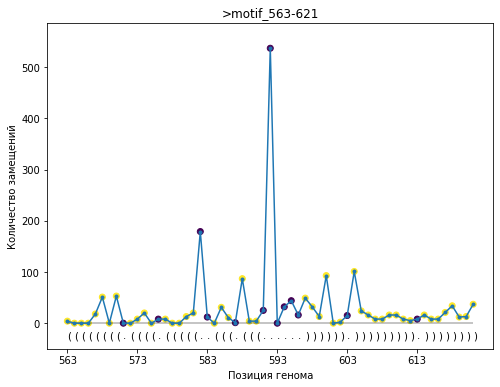

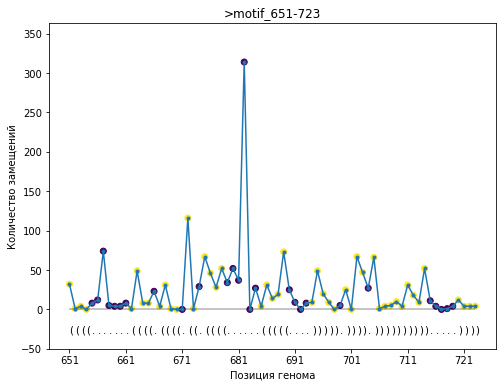

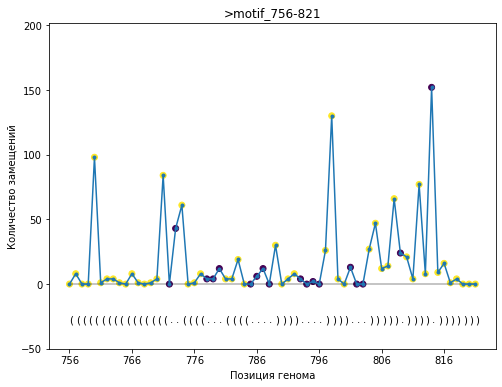

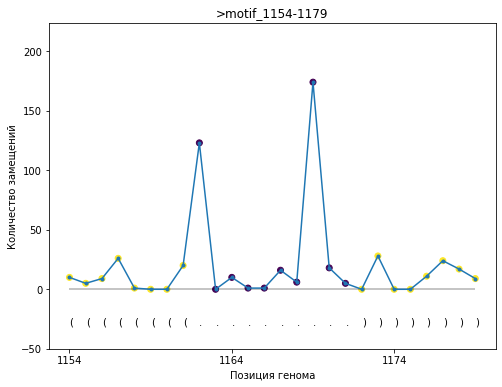

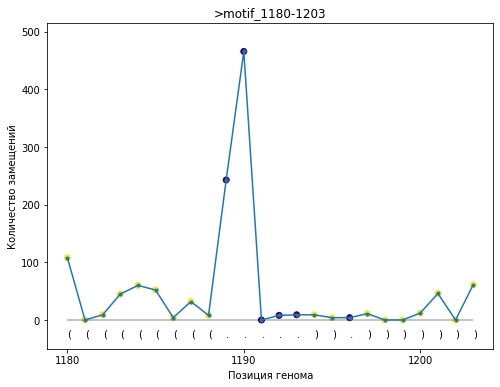

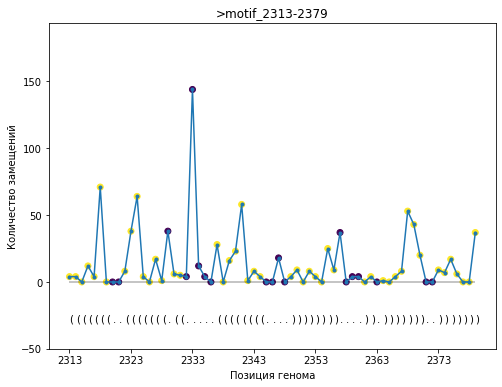

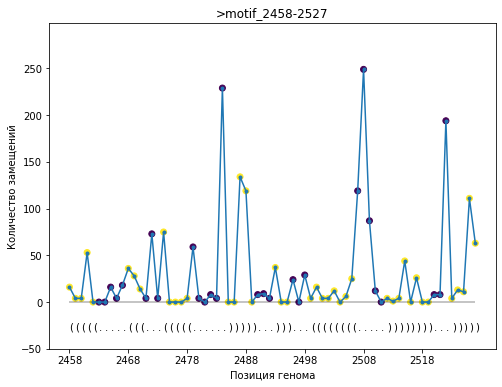

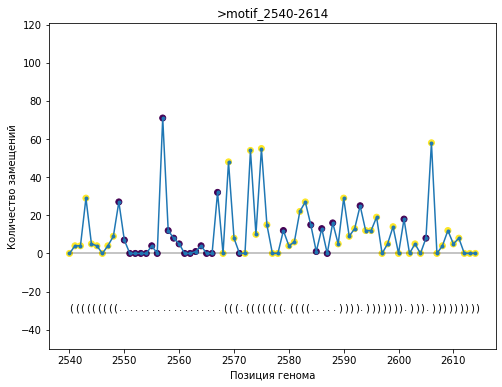

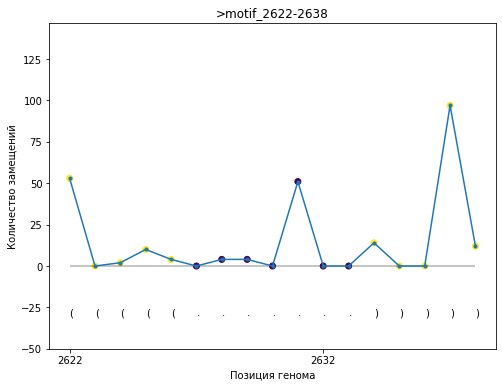

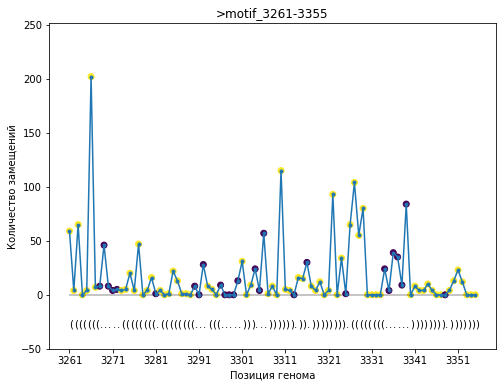

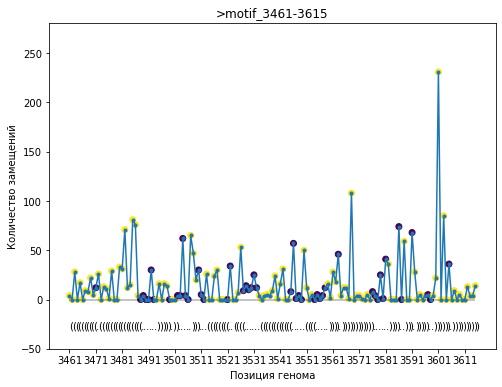

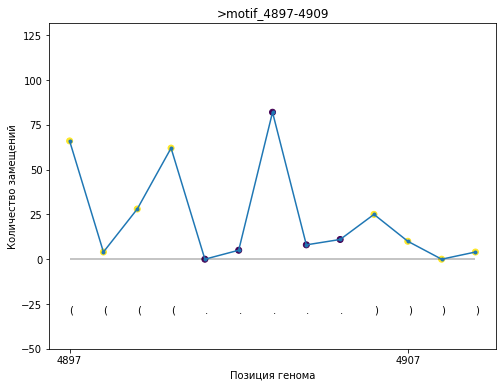

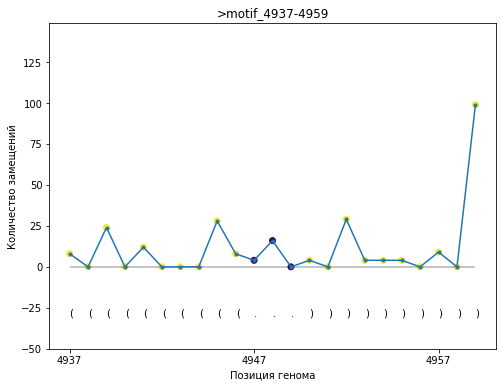

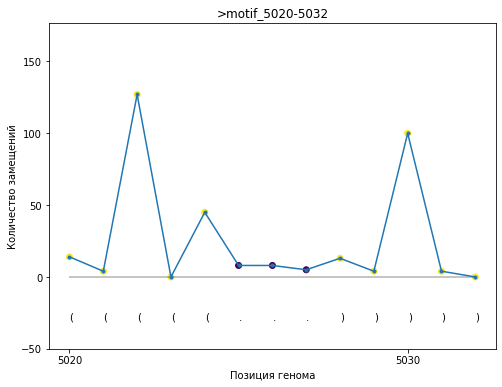

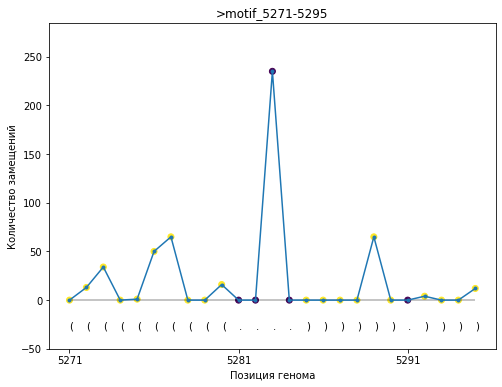

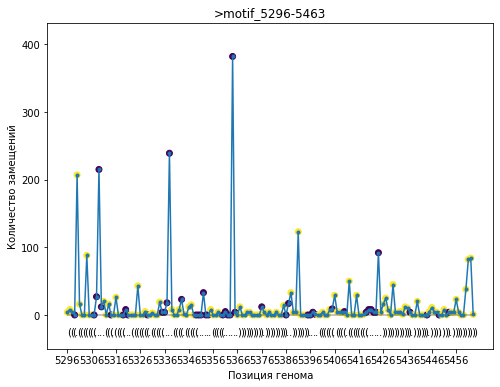

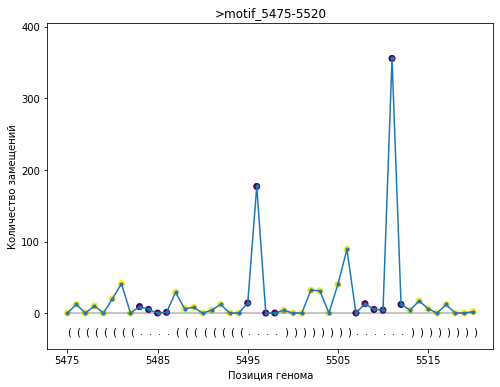

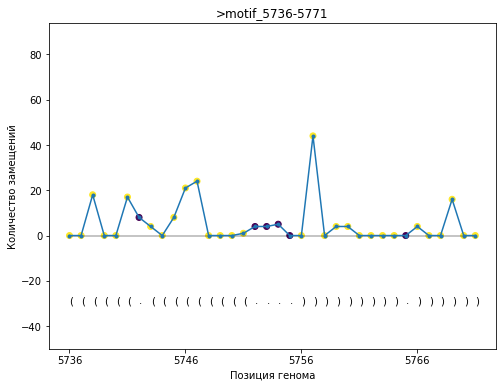

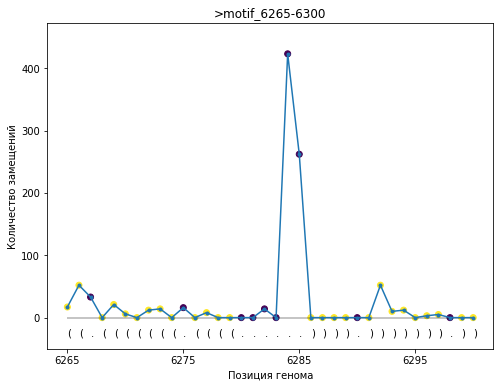

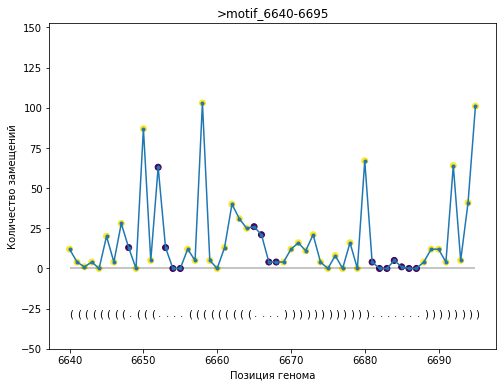

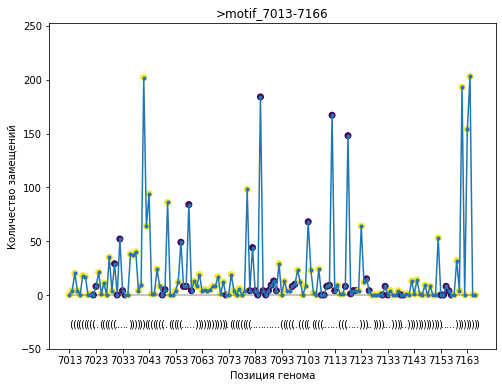

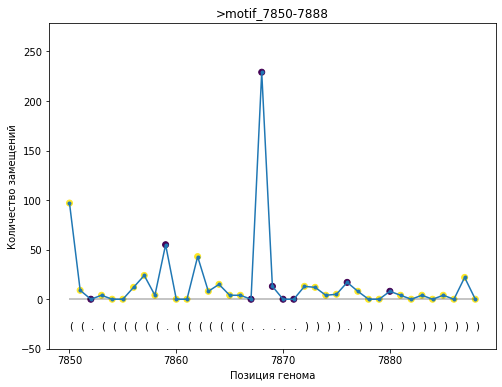

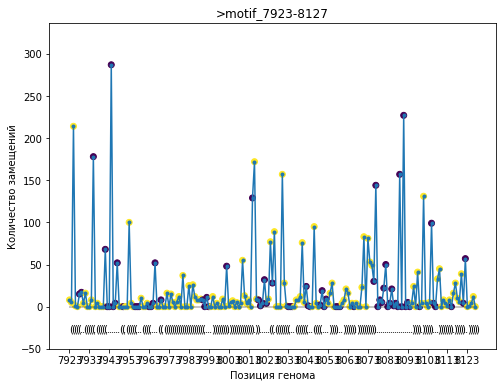

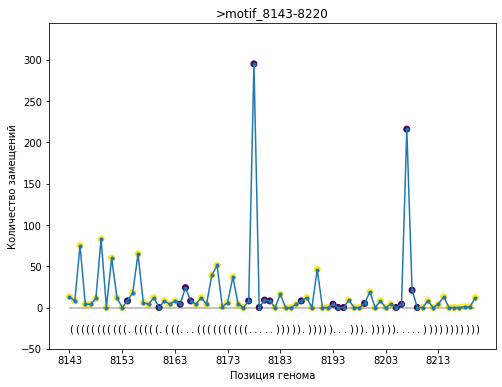

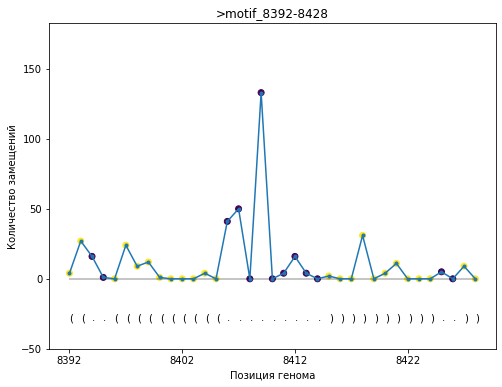

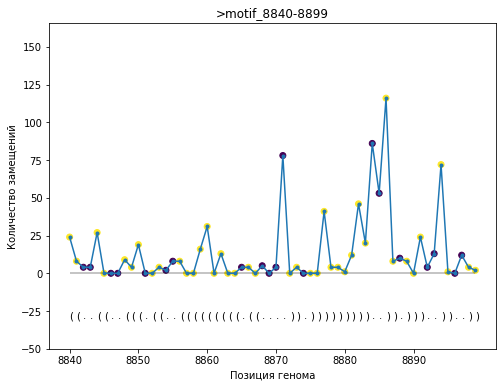

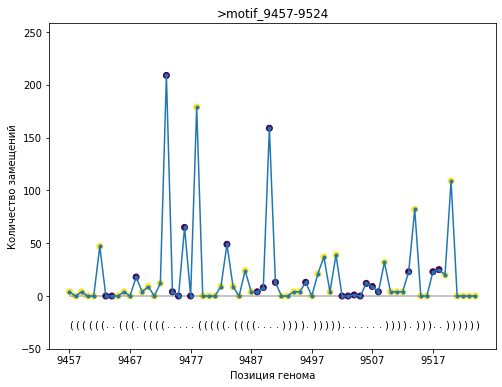

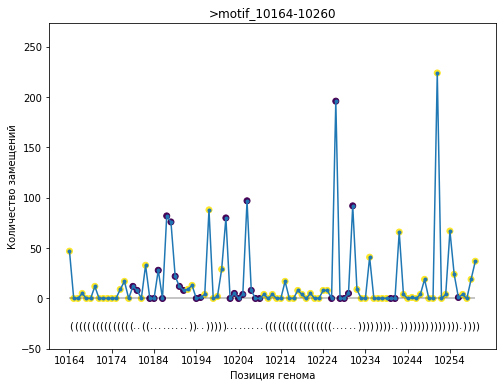

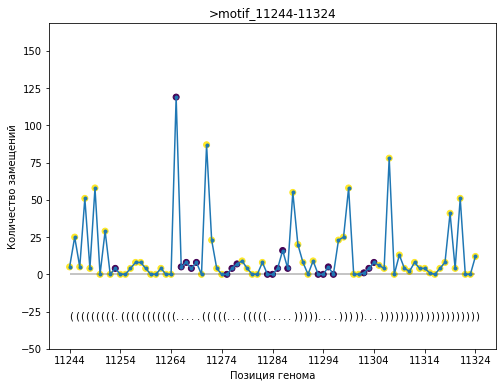

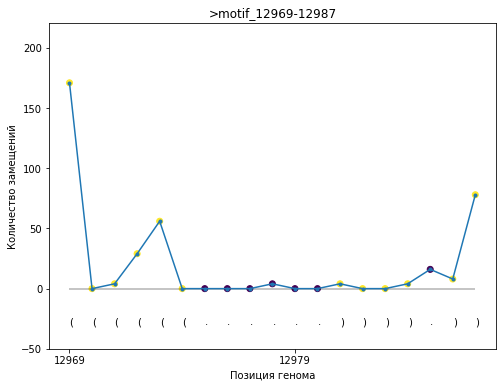

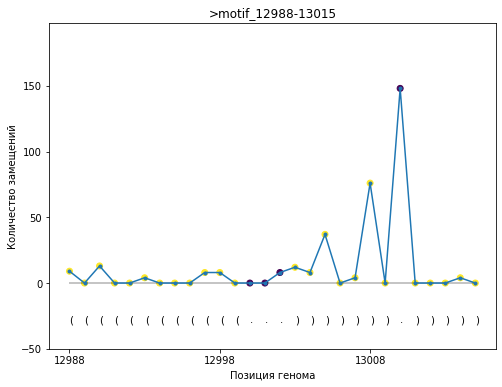

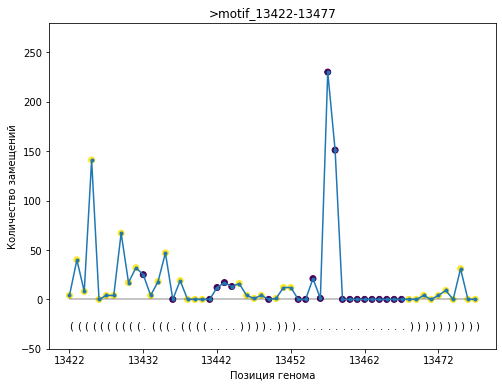

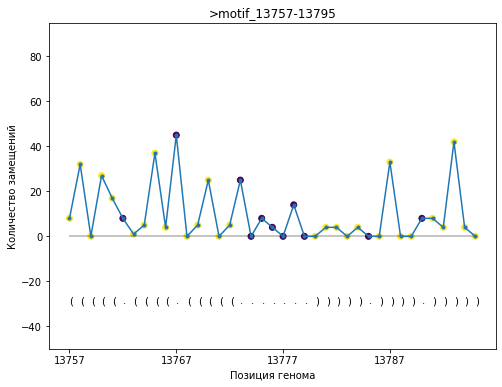

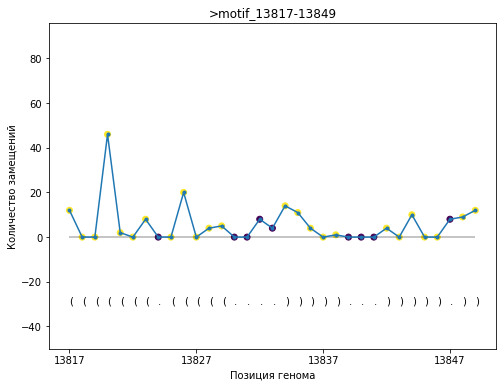

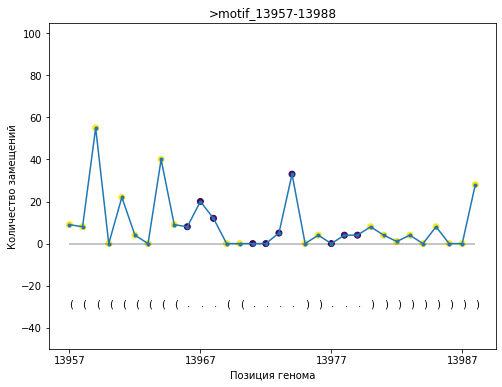

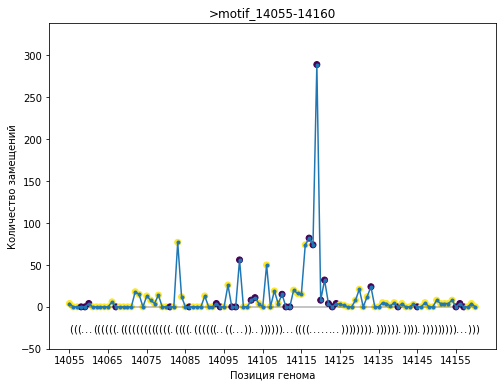

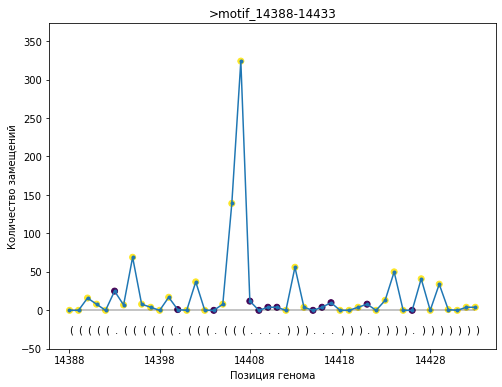

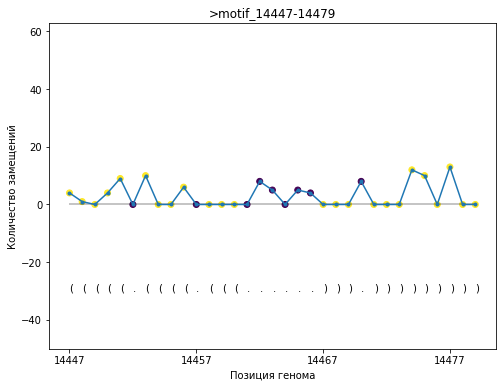

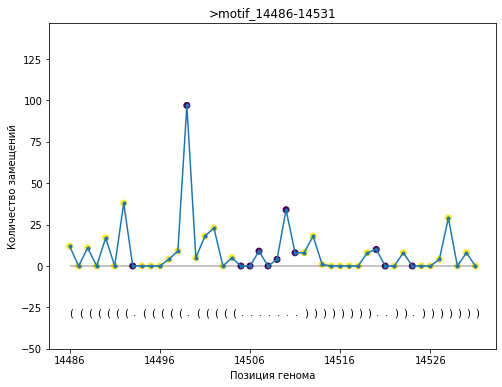

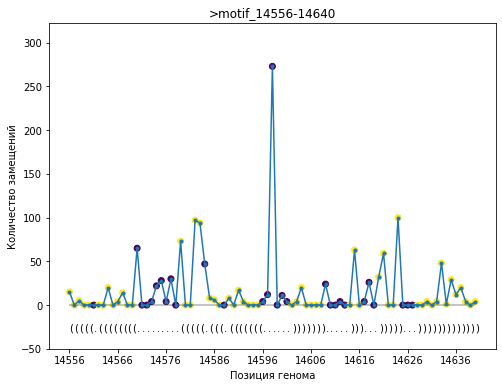

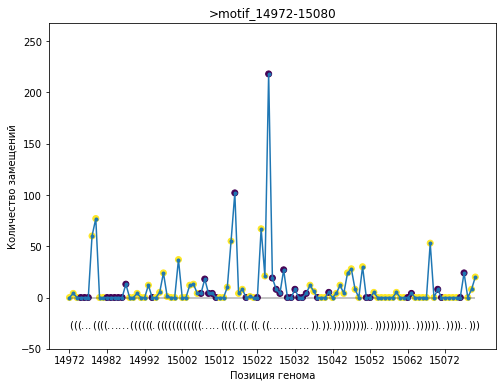

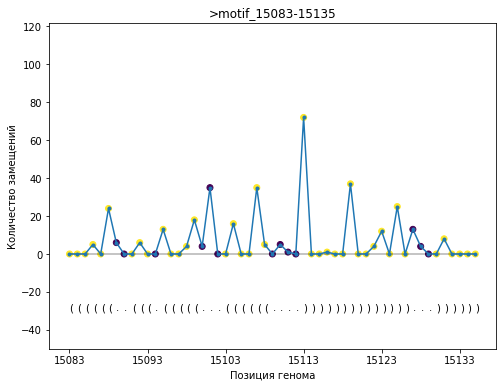

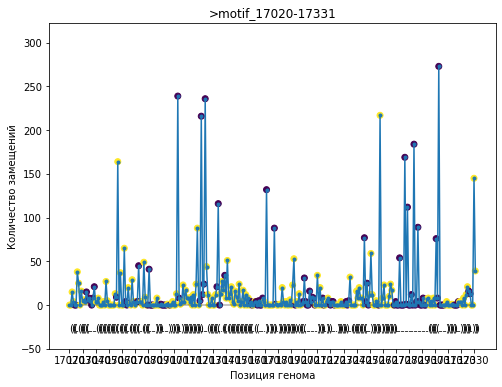

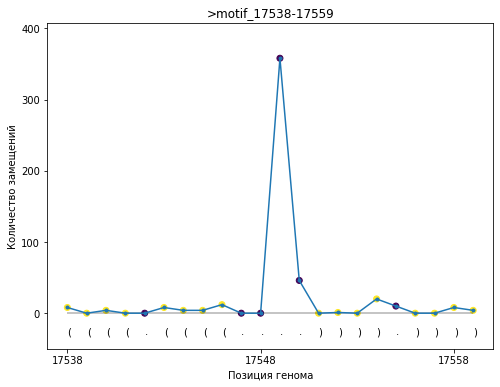

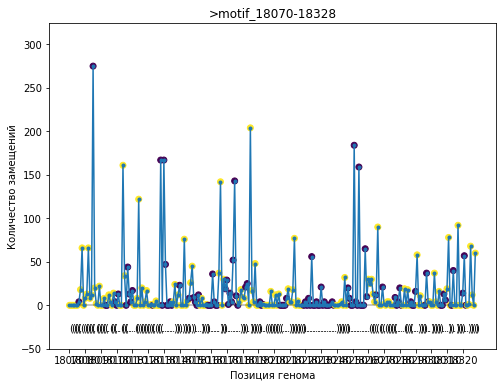

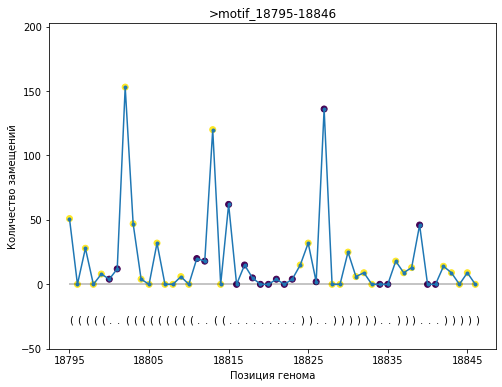

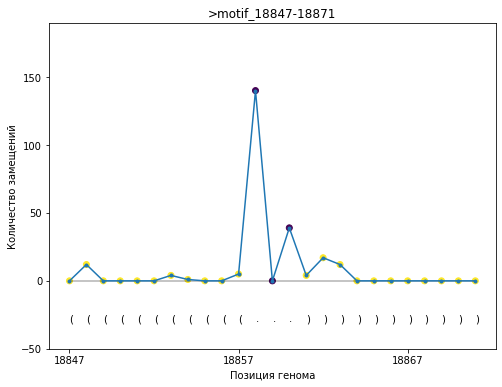

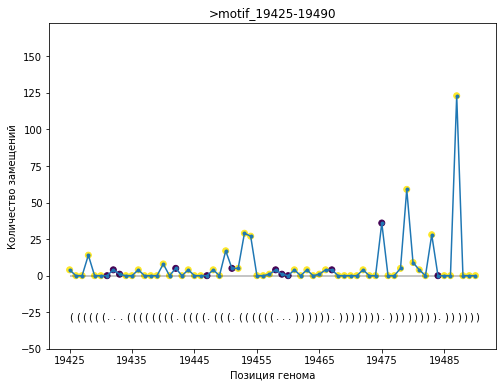

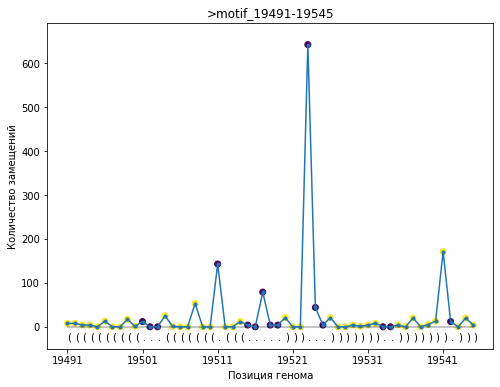

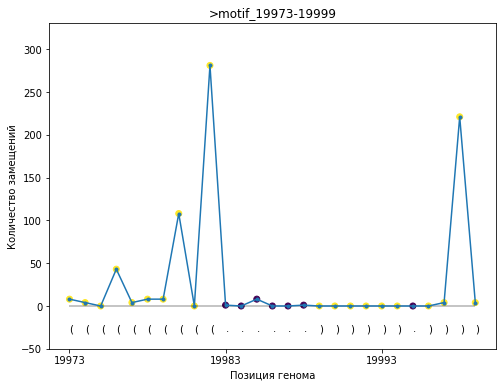

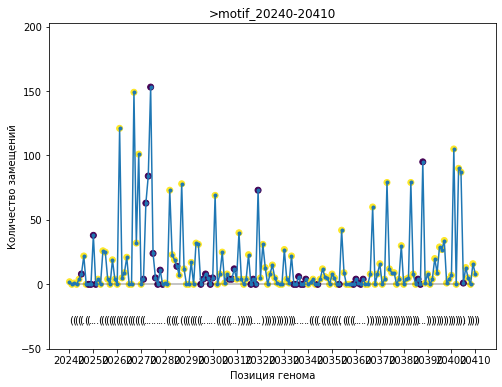

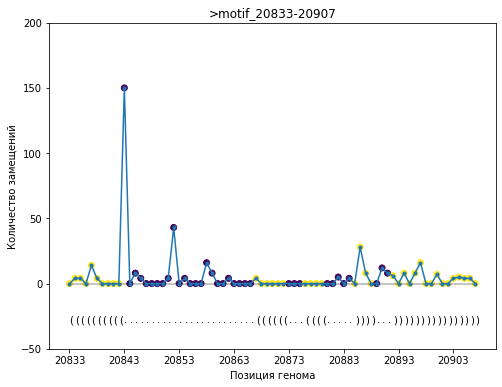

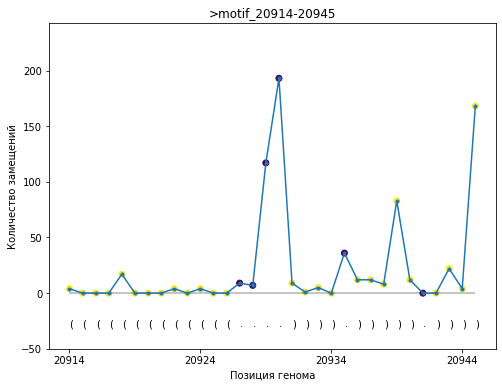

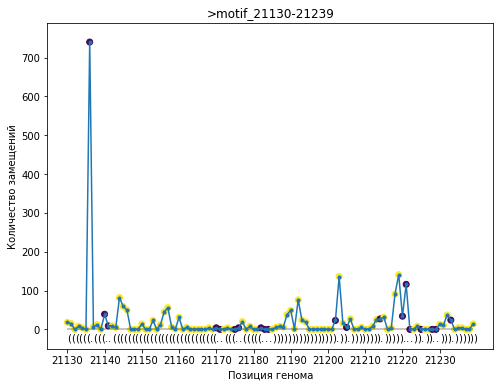

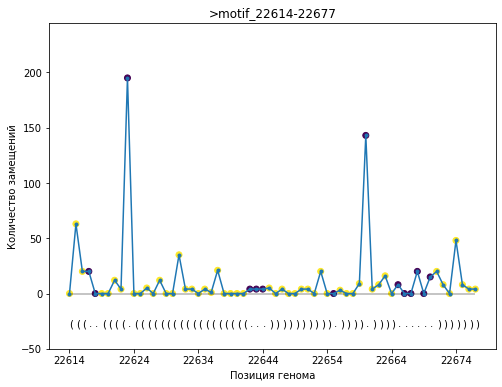

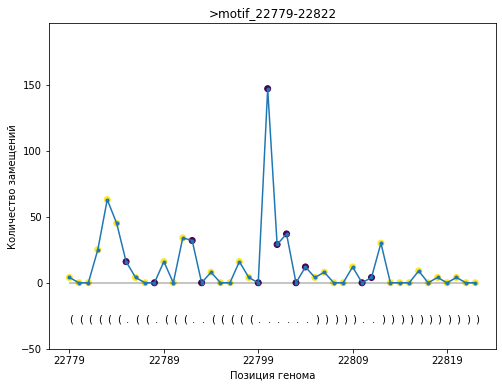

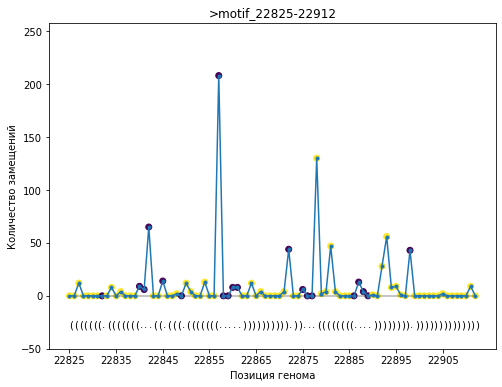

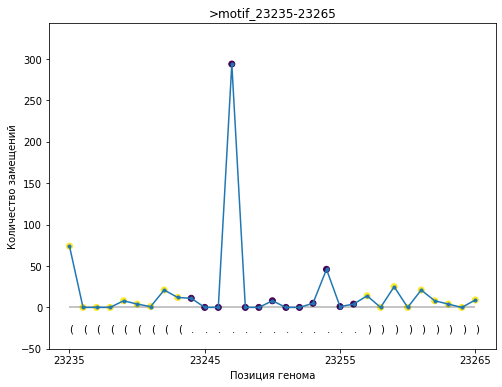

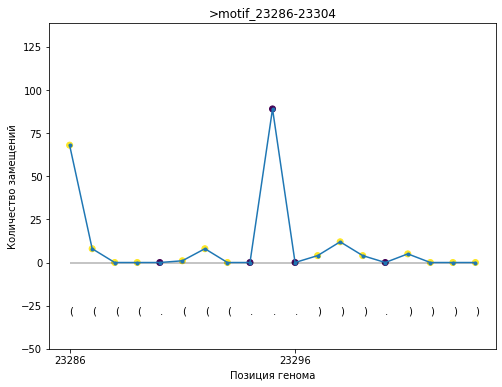

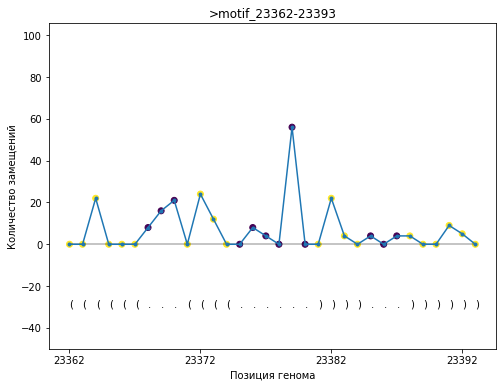

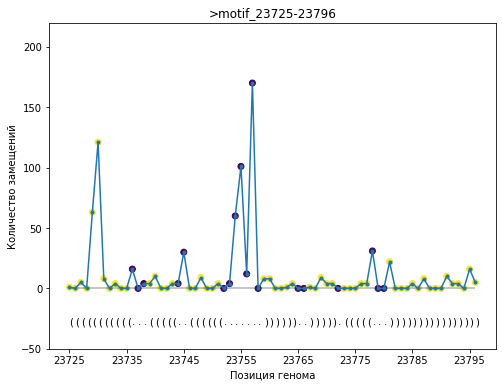

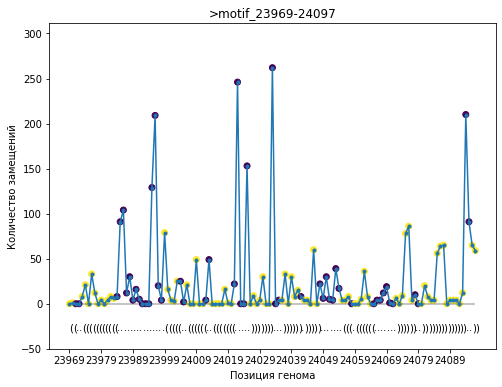

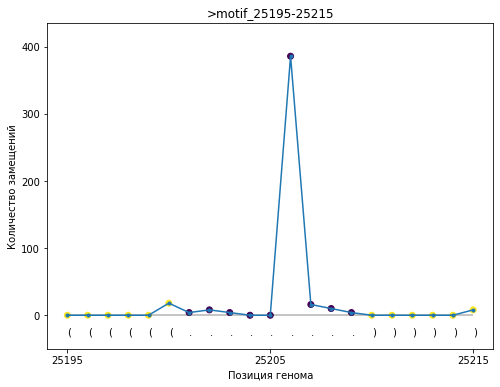

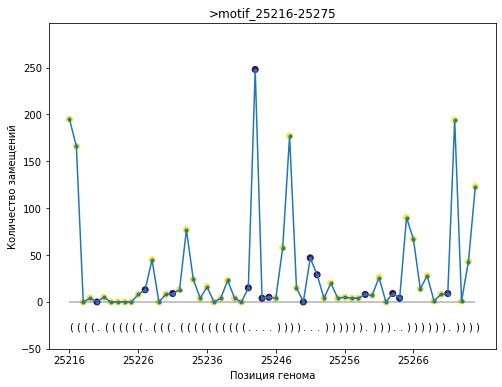

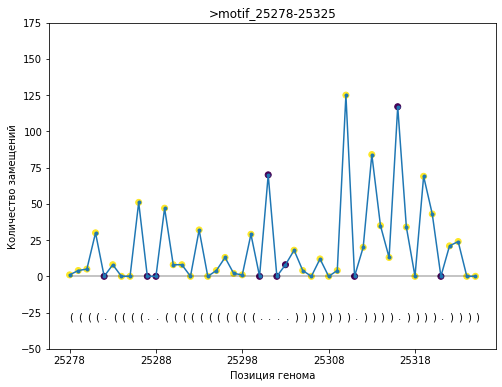

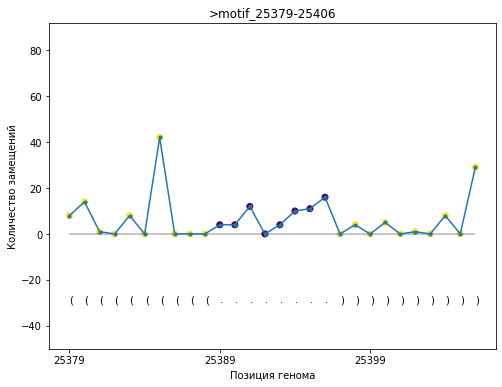

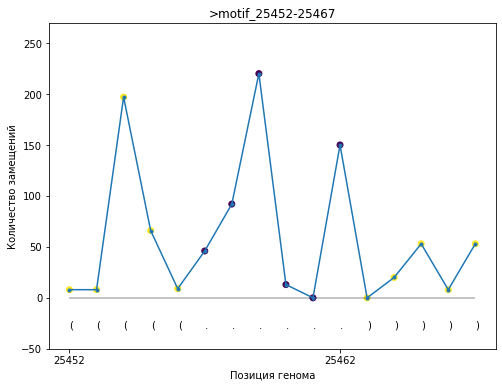

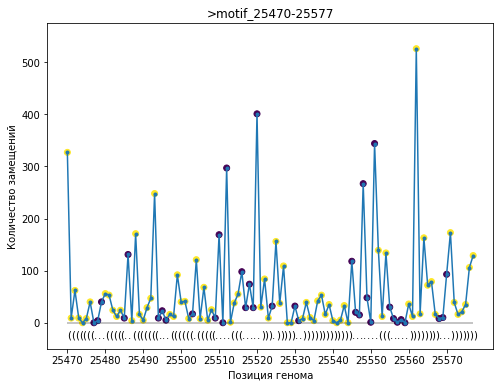

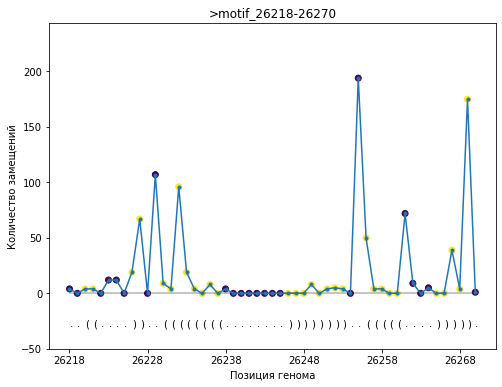

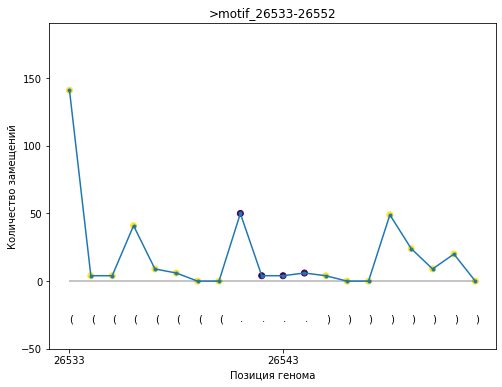

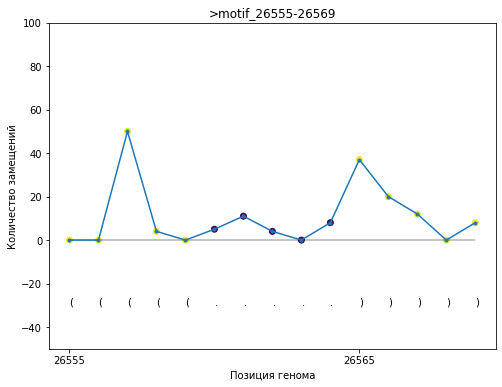

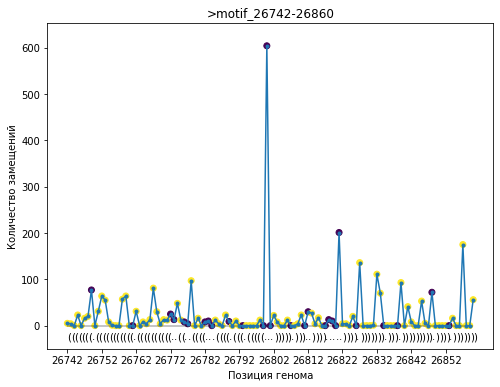

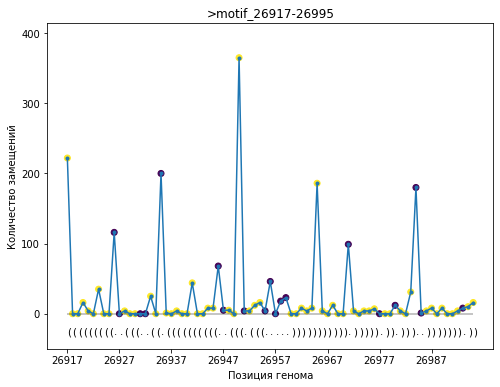

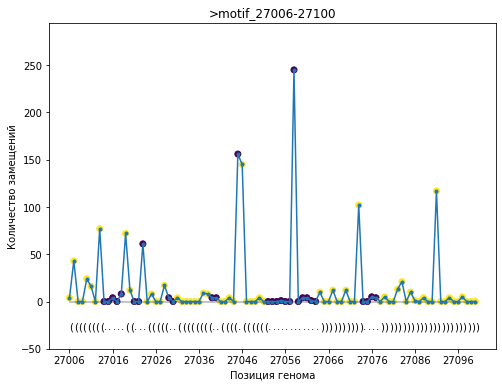

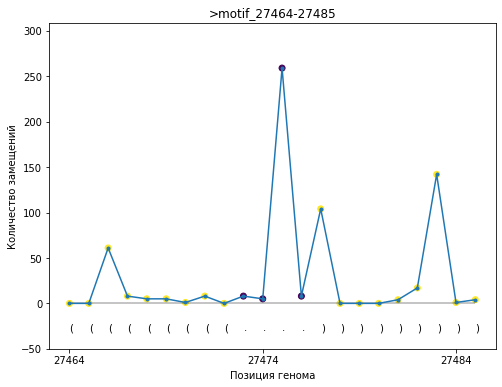

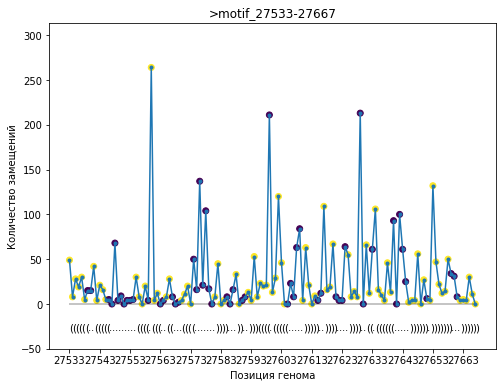

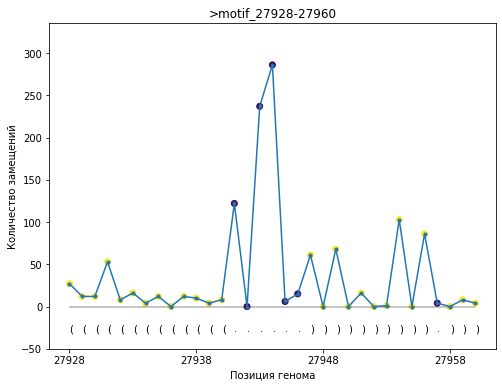

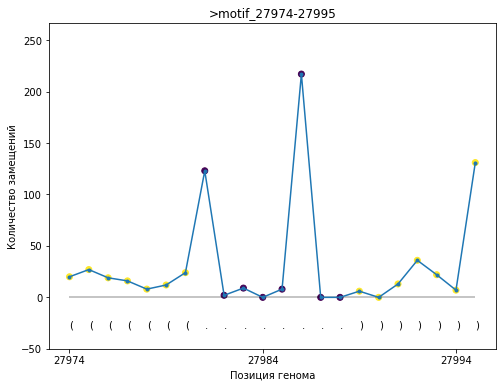

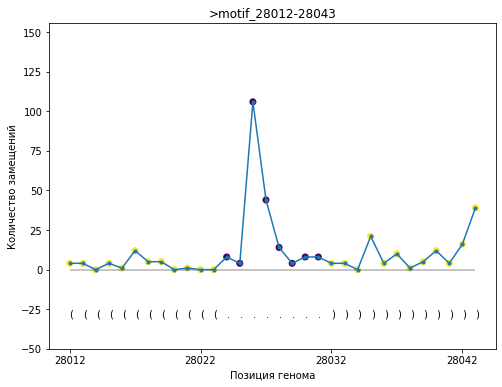

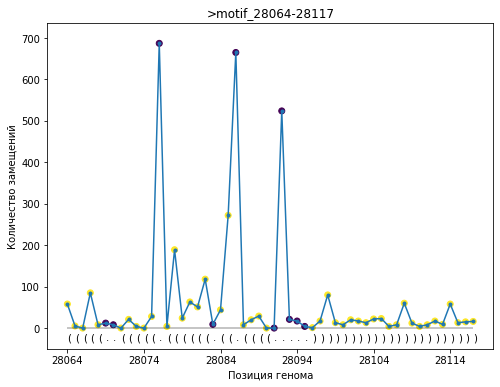

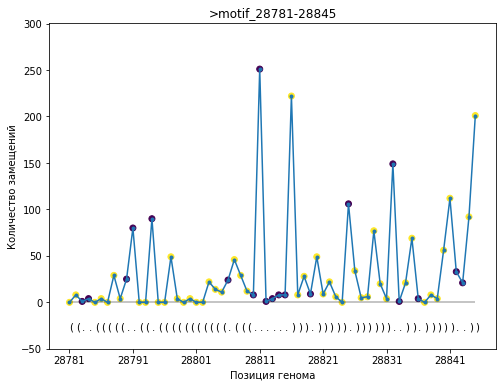

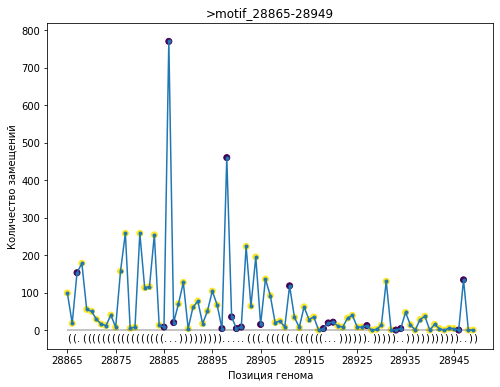

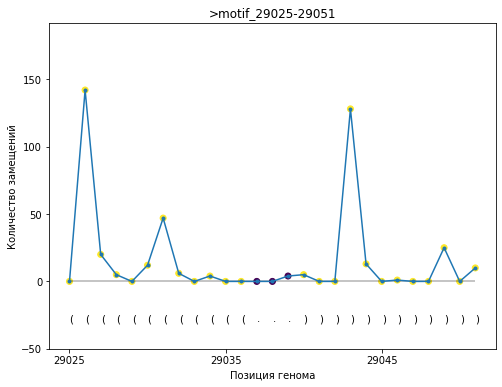

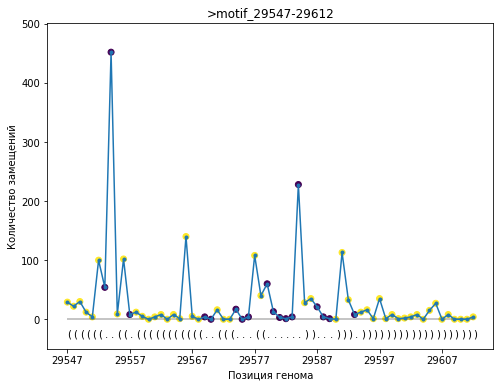

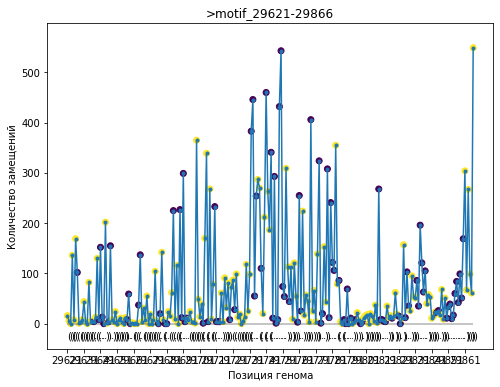

In [114]:
# https://matplotlib.org/stable/tutorials/text/text_intro.html
# https://coderoad.ru/53767304/%D0%9D%D0%B0%D1%81%D1%82%D1%80%D0%BE%D0%B9%D0%BA%D0%B0-xticks-%D0%B2-matplotlib-plot

nsubs_by_pos = np.array(list(map(len, subs_by_pos)))

for cl in ss_clusters:
    start, end = cl[1], cl[2]
    ss_seq = cl[-1]
    is_paired = np.array([x != '.' for x in ss_seq]).astype(int)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot()

    # Set titles for the figure and the subplot respectively
    ax.set_title(cl[0])
    ax.set_ylabel('Количество замещений')
    ax.set_xlabel('Позиция генома')

    x = np.arange(start, end + 1)
    y = nsubs_by_pos[x]

    ax.plot(x, y, '.-')
    ax.scatter(x, y, c=is_paired)
    for i in x:
        ax.text(i, -30, ss_seq[i - start])

    ax.hlines(0, x[0], x[-1], 'k', alpha=.3)
    ax.set_ylim((-50, y.max() + 50))
    ax.set_xticks(np.arange(start, end + 1, 10))
#     plt.show()
    filename = cl[0].lstrip('>')
    plt.savefig(f'../visual_data/nsubs_on_ss/{filename}.png')
    
#     break